<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("../input/ner-dataset/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(
            s["Word"].values.tolist(),
            s["POS"].values.tolist(),
            s["Tag"].values.tolist()
        )]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'Sajedinia': 1,
 'embraced': 2,
 'Separatists': 3,
 'deluxe': 4,
 'unilaterally': 5,
 'Wooden': 6,
 'Cotecna': 7,
 'Roadmap': 8,
 'choreography': 9,
 'commiserated': 10,
 'Hang': 11,
 'Bala': 12,
 'theoretical': 13,
 'egg': 14,
 'requirements': 15,
 'Forbidden': 16,
 'Chepe': 17,
 'football-shaped': 18,
 'halts': 19,
 'assessment': 20,
 'Al-Shabab': 21,
 'corp.': 22,
 'Machine': 23,
 'sniper': 24,
 'willingness': 25,
 'soothe': 26,
 'Ferrero': 27,
 'reclassify': 28,
 'abundantly': 29,
 'weakness': 30,
 'reaffirms': 31,
 'Helios': 32,
 'Ghorbanpour': 33,
 'recently-halted': 34,
 'nomads': 35,
 'retaliated': 36,
 'Armenia': 37,
 'Himalayas': 38,
 'al-Hafidh': 39,
 'flesh': 40,
 'U.S.-Mexico': 41,
 'announced': 42,
 'seek': 43,
 'weddings': 44,
 'perspective': 45,
 'Todd': 46,
 'demonstrators': 47,
 'heat-trapping': 48,
 '126.2': 49,
 'UN-Cambodian': 50,
 'Haradinaj': 51,
 'Chest': 52,
 'Doi': 53,
 'DRC': 54,
 'thriving': 55,
 'Left': 56,
 'meat-cutting': 57,
 'Moussa': 58,
 'Forecasters

### Task 5: Padding Input Sentences and Creating Train/Test Splits

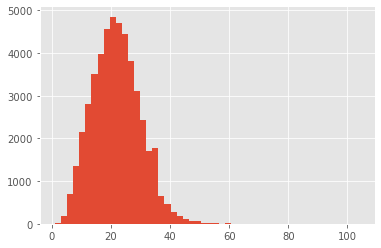

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Task 7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
%%time

chkpt = ModelCheckpoint(
    "model_weights.h5", 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=1, 
    verbose=0, 
    mode='max', 
    baseline=None, 
    restore_best_weights=False
)

callbacks = [chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
1199/1199 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9579
Epoch 00001: val_loss improved from inf to 0.06709, saving model to model_weights.h5
1199/1199 [==============================] - 424s 354ms/step - loss: 0.1817 - accuracy: 0.9579 - val_loss: 0.0671 - val_accuracy: 0.9810
Epoch 2/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9851
Epoch 00002: val_loss improved from 0.06709 to 0.05045, saving model to model_weights.h5
1199/1199 [==============================] - 423s 353ms/step - loss: 0.0503 - accuracy: 0.9851 - val_loss: 0.0505 - val_accuracy: 0.9849
Epoch 3/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9888
Epoch 00003: val_loss improved from 0.05045 to 0.04797, saving model to model_weights.h5
1199/1199 [==============================] - 420s 351ms/step - loss: 0.0366 - accuracy: 0.9888 - val_loss: 0.0480 - val_accuracy: 0.9858
CPU times: user 30min 33s, sys: 4mi

### Task 8: Evaluate Named Entity Recognition Model

In [19]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 8s 27ms/step - loss: 0.0480 - accuracy: 0.9858


[0.04797462001442909, 0.9858402609825134]

In [21]:
i = np.random.randint(1, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Rwandan        B-gpe	B-gpe
President      B-per	B-per
Paul           I-per	I-per
Kagame         I-per	I-per
says           O	O
his            O	O
country        O	O
may            O	O
pull           O	O
its            O	O
troops         O	O
from           O	O
the            O	O
African        B-geo	B-geo
Union          I-geo	I-geo
peacekeeping   O	O
force          O	O
in             O	O
Sudan          B-geo	B-geo
's             O	O
war-torn       O	O
Darfur         O	B-geo
region         O	O
.              O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonessential   O	O
nonesse